###  importing relevant libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
from numpy import array
from random import random
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB#57
from sklearn.naive_bayes import GaussianNB#52
from sklearn.naive_bayes import MultinomialNB#56
from sklearn.naive_bayes import CategoricalNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import csv
import math
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
import time



### Discovering Labels

In [3]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [4]:
def folder(f_name): #this function creates a folder.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("Tthe folder could not be created!")

In [5]:
def find_the_way(path,file_format):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                files_add.append(os.path.join(r, file))  
    return files_add

# Aggregation Algorithm notmal

In [7]:
altime=0
#def most_frequent(List): 
#    return max(set(List), key = List.count) 


 
def most_frequent(List):
    occurence_count = Counter(List)
    occurence_count={k: v for k, v in sorted(occurence_count.items(), key=lambda item: item[1],reverse=True)}
    big=list(occurence_count.values())
    big=big.count(big[0])
    return list(occurence_count.keys())[np.random.randint(big)]


def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
def create_exception(df): 
    exception_list=[]
    dominant_mac=[]
    for i in df['aggregated'].unique():
        k=df[df['aggregated']==i]
        for ii in ['MAC']:
            hist = {}
            for x in k[ii].values:
                hist[x] = hist.get(x, 0) + 1
            hist=dict(sorted(hist.items(), key=lambda item: item[1],reverse=True))
            temp=next(iter(hist))
            if temp not in dominant_mac:
                dominant_mac.append(temp)
            else:
                exception_list.append(temp)
    return exception_list




def merged(m_test,predict,step,mixed):
    second=time.time()
    mac_test=[]
    for q in m_test.index:
        mac_test.append(m_test[q])

    d_list=sorted(list(m_test.unique()))
    devices={}
    for q in d_list:
        devices[q]=[]    


    new_y=[0]*len(m_test)

    for q,qq in enumerate (mac_test):
        devices[qq].append(q)
    for q in devices:
        a = [devices[q][j:j + step] for j in range(0, len(devices[q]), step)]  
        for qq in a:
            step_list=[]
            for qqq in qq:
                step_list.append(predict[qqq])
            add=most_frequent(list(step_list))
            for qqq in qq:
                new_y[qqq]=add
    results=pd.DataFrame(m_test)
    results["aggregated"]=new_y
    results["normal"]=predict
    
    #MIXED METHOD
    if mixed:
        exception=create_exception(results)
        for q in exception:
            results.loc[results.MAC == q, 'aggregated'] = results['normal']

    return results["aggregated"].values,time.time()-second














## Calculation of evaluations

In [8]:
def score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii):
    precision=[]
    recall=[]
    f1=[]
    accuracy=[]
    total_time=[]
    kappa=[]
    accuracy_b=[]
    
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")        
    report = classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    precision.append(float(pr))
    recall.append(float(rc))
    f1.append(float(f_1))
    accuracy_b.append(balanced_accuracy_score( y_test,predict))
    accuracy.append(accuracy_score(y_test, predict))

    kappa.append(round(float(sklearn.metrics.cohen_kappa_score(y_test, predict, 
    labels=None, weights=None, sample_weight=None)),15))
    print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-8s %-5s %-8s %-8s%-8s%-8s' % (dname,i,cv,ii[0:6],str(round(np.mean(accuracy),2)),str(round(np.mean(accuracy_b),2)),
        str(round(np.mean(precision),2)), str(round(np.mean(recall),2)),str(round(np.mean(f1),4)), 
        str(round(np.mean(kappa),2)),str(round(np.mean(train_time),2)),str(round(np.mean(test_time),2)),str(round(np.mean(test_time)+np.mean(train_time),2)),str(round(np.mean(altime),2))))
    lines=(str(dname)+","+str(i)+","+str(cv)+","+str(ii)+","+str(round(np.mean(accuracy),15))+","+str(round(np.mean(accuracy_b),15))+","+str(round(np.mean(precision),15))+","+ str(round(np.mean(recall),15))+","+str(round(np.mean(f1),15))+","+str(round(np.mean(kappa),15))+","+str(round(np.mean(train_time),15))+","+str(round(np.mean(test_time),15))+","+str(altime)+"\n")
    return lines,class_based_results

In [19]:
def ML(loop1,loop2,output_csv,cols,step,mixed,dname):

    ths = open(output_csv, "w")
    ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,Al-Time\n")
    

    from sklearn.metrics import balanced_accuracy_score
    from sklearn.preprocessing import Normalizer
    
    for ii in ml_list:
        print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-8s %-5s %-8s %-8s%-8s%-8s'%
               ("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total","al-time"))
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0

        repetition=100
        for i in range(repetition):



            #TRAIN
            df = pd.read_csv(loop1,usecols=cols)
            m_train=df["MAC"]
            del df["MAC"]
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  

            #TEST
            df = pd.read_csv(loop2,usecols=cols)
            df = shuffle(df, random_state=42)
            m_test=df["MAC"]
            del df["MAC"]
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes




            results_y=[]
            cv+=1
            results_y.append(y_test)


     
   

            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time=(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time=(float((time.time()-second)) )
            if step==1:
                altime=0
                lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            else:
                predict,altime=merged(m_test,predict,step,mixed)
                lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            ths.write (lines)


            df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)
            
        class_based_results=class_based_results/repetition
        print(class_based_results)
        class_based_results.to_csv("class_based_results.csv")
        if False:
            cm=cm//repetition
            graph_name=output_csv+ii+"_confusion matrix.pdf"   
            plt.figure(figsize = (40,28))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


            
            
            
            
            
            
            


    ths.close()  

# Machine learning applications 

# Aalto Dataset ML Results -  100 repetitions

In [20]:
feature= ['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_ihl', 'IP_tos', 'IP_len', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_dataofs', 'TCP_FIN', 'TCP_ACK', 'TCP_window', 'UDP_len', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_qdcount', 'dport_class', 'payload_bytes', 'entropy',
"MAC",
'Label']


In [21]:
ml_list={"DT" :DecisionTreeClassifier(criterion='gini', max_depth=26.0,
                       max_features=26,min_samples_split= 6)}
dataset="./Aalto/"
folder(dataset)


In [22]:
test='Aalto_test_IoTDevID.csv'
train='Aalto_train_IoTDevID.csv'






dataset="./Aalto/False/"
folder(dataset)

mixed=False
for i in range(1,26):
    step=i
    sayac=1
    output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
    target_names=target_name(test)
    ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Aalto/False_1   0   1   DT      0.71  0.71  0.78  0.71  0.7275   0.68  0.16     0.0     0.16    0.0     
Aalto/False_1   1   2   DT      0.71  0.71  0.78  0.71  0.7285   0.68  0.15     0.02    0.17    0.0     
Aalto/False_1   2   3   DT      0.7   0.71  0.77  0.71  0.7271   0.68  0.15     0.01    0.16    0.0     
Aalto/False_1   3   4   DT      0.71  0.7   0.78  0.7   0.728    0.68  0.15     0.02    0.16    0.0     
Aalto/False_1   4   5   DT      0.71  0.71  0.78  0.71  0.7278   0.68  0.17     0.01    0.18    0.0     
Aalto/False_1   5   6   DT      0.7   0.71  0.78  0.71  0.7275   0.68  0.16     0.01    0.17    0.0     
Aalto/False_1   6   7   DT      0.7   0.71  0.77  0.71  0.7267   0.68  0.15     0.0     0.15    0.0     
Aalto/False_1   7   8   DT      0.71  0.7   0.78  0.7   0.7282   0.68  0.16     0.01    0.17    0.0     
Aalto/False_1   8   9   DT      0.7   0.71  0.77  0.71 

Aalto/False_1   78  79  DT      0.7   0.71  0.77  0.71  0.7258   0.68  0.18     0.01    0.19    0.0     
Aalto/False_1   79  80  DT      0.7   0.7   0.76  0.7   0.7236   0.68  0.16     0.01    0.17    0.0     
Aalto/False_1   80  81  DT      0.71  0.71  0.78  0.71  0.7275   0.68  0.16     0.0     0.16    0.0     
Aalto/False_1   81  82  DT      0.7   0.7   0.78  0.7   0.7274   0.68  0.15     0.0     0.15    0.0     
Aalto/False_1   82  83  DT      0.7   0.7   0.77  0.7   0.7248   0.67  0.14     0.02    0.15    0.0     
Aalto/False_1   83  84  DT      0.71  0.71  0.78  0.71  0.729    0.68  0.16     0.01    0.16    0.0     
Aalto/False_1   84  85  DT      0.71  0.7   0.77  0.7   0.7268   0.68  0.16     0.0     0.16    0.0     
Aalto/False_1   85  86  DT      0.7   0.71  0.77  0.71  0.7276   0.68  0.17     0.0     0.17    0.0     
Aalto/False_1   86  87  DT      0.7   0.7   0.77  0.7   0.7268   0.68  0.15     0.0     0.15    0.0     
Aalto/False_1   87  88  DT      0.71  0.71  0.78  0.71 

Aalto/False_2   37  38  DT      0.64  0.68  0.74  0.68  0.6992   0.6   0.19     0.01    0.19    0.22    
Aalto/False_2   38  39  DT      0.64  0.68  0.75  0.68  0.6999   0.61  0.15     0.01    0.16    0.22    
Aalto/False_2   39  40  DT      0.65  0.69  0.75  0.69  0.7092   0.61  0.16     0.01    0.17    0.28    
Aalto/False_2   40  41  DT      0.64  0.68  0.74  0.68  0.7001   0.6   0.19     0.01    0.2     0.24    
Aalto/False_2   41  42  DT      0.64  0.67  0.75  0.67  0.691    0.61  0.18     0.01    0.19    0.26    
Aalto/False_2   42  43  DT      0.64  0.68  0.75  0.68  0.7051   0.61  0.17     0.01    0.18    0.27    
Aalto/False_2   43  44  DT      0.64  0.67  0.75  0.67  0.6944   0.61  0.15     0.02    0.16    0.19    
Aalto/False_2   44  45  DT      0.65  0.68  0.75  0.68  0.7034   0.61  0.15     0.02    0.16    0.22    
Aalto/False_2   45  46  DT      0.65  0.69  0.76  0.69  0.71     0.61  0.16     0.01    0.17    0.22    
Aalto/False_2   46  47  DT      0.65  0.68  0.75  0.68 

Aalto/False_3   0   1   DT      0.69  0.75  0.81  0.75  0.7584   0.66  0.15     0.02    0.16    0.2     
Aalto/False_3   1   2   DT      0.68  0.73  0.79  0.73  0.7395   0.65  0.16     0.02    0.17    0.18    
Aalto/False_3   2   3   DT      0.68  0.74  0.79  0.74  0.7527   0.65  0.16     0.02    0.18    0.22    
Aalto/False_3   3   4   DT      0.69  0.75  0.79  0.75  0.7548   0.66  0.17     0.02    0.19    0.24    
Aalto/False_3   4   5   DT      0.69  0.74  0.79  0.74  0.7515   0.66  0.17     0.02    0.18    0.22    
Aalto/False_3   5   6   DT      0.69  0.75  0.8   0.75  0.7595   0.66  0.18     0.01    0.18    0.25    
Aalto/False_3   6   7   DT      0.68  0.73  0.8   0.73  0.7449   0.65  0.41     0.0     0.41    0.18    
Aalto/False_3   7   8   DT      0.68  0.74  0.79  0.74  0.7481   0.65  0.17     0.02    0.18    0.24    
Aalto/False_3   8   9   DT      0.68  0.74  0.79  0.74  0.7484   0.65  0.2      0.0     0.2     0.27    
Aalto/False_3   9   10  DT      0.68  0.74  0.8   0.74 

Aalto/False_3   79  80  DT      0.68  0.74  0.79  0.74  0.7478   0.65  0.17     0.01    0.18    0.21    
Aalto/False_3   80  81  DT      0.69  0.74  0.8   0.74  0.7548   0.66  0.18     0.01    0.19    0.24    
Aalto/False_3   81  82  DT      0.69  0.74  0.8   0.74  0.7517   0.66  0.2      0.01    0.21    0.25    
Aalto/False_3   82  83  DT      0.69  0.74  0.8   0.74  0.7533   0.65  0.22     0.01    0.23    0.28    
Aalto/False_3   83  84  DT      0.68  0.73  0.79  0.73  0.7428   0.65  0.21     0.01    0.22    0.28    
Aalto/False_3   84  85  DT      0.69  0.74  0.8   0.74  0.7561   0.66  0.21     0.01    0.22    0.31    
Aalto/False_3   85  86  DT      0.69  0.74  0.8   0.74  0.7497   0.65  0.2      0.01    0.21    0.3     
Aalto/False_3   86  87  DT      0.68  0.73  0.79  0.73  0.7417   0.65  0.21     0.01    0.22    0.32    
Aalto/False_3   87  88  DT      0.68  0.73  0.79  0.73  0.7472   0.65  0.17     0.01    0.18    0.22    
Aalto/False_3   88  89  DT      0.68  0.73  0.8   0.73 

Aalto/False_4   38  39  DT      0.69  0.77  0.82  0.77  0.7717   0.66  0.21     0.01    0.21    0.21    
Aalto/False_4   39  40  DT      0.7   0.77  0.82  0.77  0.7767   0.67  0.26     0.01    0.27    0.27    
Aalto/False_4   40  41  DT      0.7   0.77  0.82  0.77  0.7781   0.67  0.18     0.01    0.19    0.27    
Aalto/False_4   41  42  DT      0.7   0.77  0.82  0.77  0.7766   0.67  0.17     0.01    0.17    0.18    
Aalto/False_4   42  43  DT      0.7   0.76  0.82  0.76  0.7722   0.67  0.19     0.01    0.2     0.22    
Aalto/False_4   43  44  DT      0.7   0.77  0.82  0.77  0.7745   0.67  0.24     0.01    0.25    0.3     
Aalto/False_4   44  45  DT      0.7   0.77  0.82  0.77  0.7747   0.67  0.18     0.01    0.19    0.21    
Aalto/False_4   45  46  DT      0.69  0.76  0.82  0.76  0.7714   0.66  0.2      0.01    0.21    0.21    
Aalto/False_4   46  47  DT      0.7   0.77  0.82  0.77  0.7781   0.67  0.23     0.01    0.24    0.34    
Aalto/False_4   47  48  DT      0.7   0.77  0.82  0.77 

Aalto/False_5   0   1   DT      0.71  0.77  0.83  0.77  0.7758   0.68  0.2      0.01    0.21    0.21    
Aalto/False_5   1   2   DT      0.71  0.78  0.83  0.78  0.7851   0.68  0.18     0.01    0.18    0.24    
Aalto/False_5   2   3   DT      0.71  0.78  0.83  0.78  0.7799   0.68  0.24     0.01    0.25    0.29    
Aalto/False_5   3   4   DT      0.71  0.77  0.83  0.77  0.7764   0.68  0.22     0.01    0.23    0.26    
Aalto/False_5   4   5   DT      0.71  0.78  0.83  0.78  0.7806   0.68  0.23     0.01    0.24    0.23    
Aalto/False_5   5   6   DT      0.71  0.77  0.83  0.77  0.7727   0.68  0.19     0.01    0.2     0.24    
Aalto/False_5   6   7   DT      0.71  0.78  0.83  0.78  0.7826   0.68  0.19     0.01    0.2     0.21    
Aalto/False_5   7   8   DT      0.71  0.77  0.83  0.77  0.7732   0.68  0.19     0.01    0.2     0.18    
Aalto/False_5   8   9   DT      0.71  0.78  0.83  0.78  0.7781   0.68  0.17     0.01    0.17    0.16    
Aalto/False_5   9   10  DT      0.71  0.78  0.83  0.78 

Aalto/False_5   79  80  DT      0.71  0.77  0.83  0.77  0.7769   0.68  0.15     0.0     0.15    0.19    
Aalto/False_5   80  81  DT      0.71  0.77  0.83  0.77  0.7737   0.68  0.19     0.01    0.2     0.16    
Aalto/False_5   81  82  DT      0.71  0.77  0.82  0.77  0.7767   0.68  0.17     0.02    0.18    0.22    
Aalto/False_5   82  83  DT      0.71  0.78  0.83  0.78  0.7813   0.68  0.2      0.01    0.21    0.25    
Aalto/False_5   83  84  DT      0.71  0.77  0.83  0.77  0.7749   0.68  0.16     0.0     0.16    0.17    
Aalto/False_5   84  85  DT      0.71  0.77  0.83  0.77  0.7763   0.68  0.15     0.02    0.17    0.17    
Aalto/False_5   85  86  DT      0.71  0.77  0.82  0.77  0.7761   0.68  0.17     0.02    0.19    0.16    
Aalto/False_5   86  87  DT      0.72  0.79  0.83  0.79  0.7876   0.69  0.2      0.01    0.21    0.22    
Aalto/False_5   87  88  DT      0.71  0.78  0.83  0.78  0.7842   0.68  0.17     0.02    0.19    0.2     
Aalto/False_5   88  89  DT      0.71  0.77  0.83  0.77 

Aalto/False_6   38  39  DT      0.71  0.79  0.84  0.79  0.7855   0.69  0.2      0.01    0.21    0.21    
Aalto/False_6   39  40  DT      0.71  0.78  0.83  0.78  0.781    0.69  0.17     0.02    0.18    0.16    
Aalto/False_6   40  41  DT      0.72  0.79  0.84  0.79  0.7938   0.69  0.21     0.0     0.21    0.22    
Aalto/False_6   41  42  DT      0.71  0.79  0.84  0.79  0.789    0.68  0.16     0.01    0.17    0.22    
Aalto/False_6   42  43  DT      0.72  0.79  0.84  0.79  0.7935   0.69  0.18     0.0     0.18    0.19    
Aalto/False_6   43  44  DT      0.71  0.79  0.84  0.79  0.7906   0.68  0.2      0.01    0.21    0.21    
Aalto/False_6   44  45  DT      0.72  0.79  0.84  0.79  0.7907   0.69  0.16     0.0     0.16    0.2     
Aalto/False_6   45  46  DT      0.71  0.79  0.84  0.79  0.7895   0.69  0.18     0.0     0.18    0.22    
Aalto/False_6   46  47  DT      0.71  0.78  0.83  0.78  0.7858   0.69  0.18     0.02    0.2     0.2     
Aalto/False_6   47  48  DT      0.71  0.78  0.83  0.78 

Aalto/False_7   0   1   DT      0.72  0.8   0.85  0.8   0.8024   0.7   0.17     0.0     0.18    0.19    
Aalto/False_7   1   2   DT      0.73  0.8   0.85  0.8   0.7979   0.7   0.23     0.01    0.24    0.28    
Aalto/False_7   2   3   DT      0.73  0.81  0.86  0.81  0.8044   0.7   0.21     0.01    0.22    0.2     
Aalto/False_7   3   4   DT      0.73  0.81  0.86  0.81  0.8058   0.7   0.19     0.01    0.2     0.22    
Aalto/False_7   4   5   DT      0.73  0.81  0.86  0.81  0.8069   0.7   0.2      0.01    0.2     0.2     
Aalto/False_7   5   6   DT      0.73  0.8   0.86  0.8   0.8016   0.7   0.18     0.02    0.2     0.17    
Aalto/False_7   6   7   DT      0.73  0.81  0.85  0.81  0.8033   0.7   0.19     0.01    0.2     0.19    
Aalto/False_7   7   8   DT      0.73  0.8   0.85  0.8   0.8004   0.7   0.18     0.02    0.2     0.18    
Aalto/False_7   8   9   DT      0.73  0.79  0.85  0.79  0.7939   0.7   0.19     0.01    0.19    0.2     
Aalto/False_7   9   10  DT      0.73  0.8   0.85  0.8  

Aalto/False_7   79  80  DT      0.73  0.81  0.86  0.81  0.803    0.7   0.2      0.01    0.21    0.19    
Aalto/False_7   80  81  DT      0.73  0.79  0.85  0.79  0.7929   0.7   0.17     0.01    0.18    0.19    
Aalto/False_7   81  82  DT      0.73  0.8   0.85  0.8   0.7974   0.7   0.18     0.01    0.19    0.18    
Aalto/False_7   82  83  DT      0.72  0.8   0.85  0.8   0.7989   0.69  0.19     0.01    0.2     0.22    
Aalto/False_7   83  84  DT      0.73  0.79  0.85  0.79  0.7952   0.7   0.18     0.02    0.2     0.22    
Aalto/False_7   84  85  DT      0.73  0.8   0.86  0.8   0.7993   0.7   0.2      0.01    0.2     0.19    
Aalto/False_7   85  86  DT      0.72  0.79  0.85  0.79  0.7927   0.7   0.18     0.01    0.19    0.17    
Aalto/False_7   86  87  DT      0.73  0.8   0.85  0.8   0.7963   0.7   0.17     0.01    0.18    0.2     
Aalto/False_7   87  88  DT      0.73  0.8   0.85  0.8   0.7958   0.7   0.23     0.01    0.24    0.24    
Aalto/False_7   88  89  DT      0.73  0.8   0.86  0.8  

Aalto/False_8   38  39  DT      0.72  0.78  0.85  0.78  0.7807   0.69  0.19     0.01    0.2     0.22    
Aalto/False_8   39  40  DT      0.72  0.79  0.85  0.79  0.7916   0.7   0.22     0.01    0.23    0.19    
Aalto/False_8   40  41  DT      0.73  0.8   0.85  0.8   0.7998   0.7   0.19     0.0     0.19    0.22    
Aalto/False_8   41  42  DT      0.72  0.79  0.85  0.79  0.786    0.69  0.18     0.02    0.19    0.2     
Aalto/False_8   42  43  DT      0.72  0.8   0.85  0.8   0.7939   0.7   0.22     0.0     0.22    0.2     
Aalto/False_8   43  44  DT      0.73  0.79  0.85  0.79  0.7955   0.7   0.23     0.01    0.24    0.19    
Aalto/False_8   44  45  DT      0.73  0.8   0.85  0.8   0.8001   0.7   0.21     0.01    0.22    0.2     
Aalto/False_8   45  46  DT      0.73  0.79  0.85  0.79  0.7968   0.7   0.19     0.01    0.2     0.2     
Aalto/False_8   46  47  DT      0.72  0.79  0.85  0.79  0.7881   0.69  0.2      0.0     0.2     0.18    
Aalto/False_8   47  48  DT      0.73  0.8   0.85  0.8  

Aalto/False_9   0   1   DT      0.73  0.81  0.86  0.81  0.801    0.71  0.18     0.02    0.19    0.17    
Aalto/False_9   1   2   DT      0.73  0.81  0.85  0.81  0.8009   0.71  0.16     0.0     0.16    0.18    
Aalto/False_9   2   3   DT      0.73  0.8   0.86  0.8   0.794    0.71  0.17     0.02    0.19    0.17    
Aalto/False_9   3   4   DT      0.73  0.81  0.86  0.81  0.8016   0.71  0.15     0.01    0.16    0.12    
Aalto/False_9   4   5   DT      0.73  0.8   0.85  0.8   0.7948   0.7   0.16     0.02    0.18    0.14    
Aalto/False_9   5   6   DT      0.73  0.8   0.86  0.8   0.7936   0.7   0.15     0.02    0.16    0.14    
Aalto/False_9   6   7   DT      0.73  0.8   0.86  0.8   0.7945   0.71  0.17     0.0     0.17    0.15    
Aalto/False_9   7   8   DT      0.73  0.81  0.85  0.81  0.7965   0.7   0.22     0.01    0.23    0.21    
Aalto/False_9   8   9   DT      0.73  0.79  0.85  0.79  0.7868   0.7   0.18     0.01    0.19    0.18    
Aalto/False_9   9   10  DT      0.74  0.81  0.86  0.81 

Aalto/False_9   79  80  DT      0.73  0.81  0.86  0.81  0.7993   0.71  0.15     0.0     0.15    0.11    
Aalto/False_9   80  81  DT      0.73  0.81  0.86  0.81  0.7974   0.71  0.17     0.01    0.17    0.14    
Aalto/False_9   81  82  DT      0.73  0.81  0.86  0.81  0.8054   0.7   0.2      0.01    0.21    0.23    
Aalto/False_9   82  83  DT      0.73  0.81  0.86  0.81  0.8035   0.71  0.37     0.01    0.38    0.4     
Aalto/False_9   83  84  DT      0.74  0.81  0.86  0.81  0.7994   0.71  0.28     0.01    0.29    0.15    
Aalto/False_9   84  85  DT      0.73  0.81  0.85  0.81  0.8      0.71  0.16     0.01    0.17    0.13    
Aalto/False_9   85  86  DT      0.73  0.8   0.86  0.8   0.7881   0.7   0.17     0.01    0.17    0.14    
Aalto/False_9   86  87  DT      0.73  0.8   0.85  0.8   0.7952   0.7   0.16     0.01    0.16    0.16    
Aalto/False_9   87  88  DT      0.73  0.8   0.85  0.8   0.7904   0.7   0.17     0.01    0.17    0.14    
Aalto/False_9   88  89  DT      0.73  0.8   0.85  0.8  

Aalto/False_10  38  39  DT      0.73  0.79  0.85  0.79  0.7848   0.7   0.26     0.01    0.28    0.18    
Aalto/False_10  39  40  DT      0.74  0.81  0.86  0.81  0.8017   0.71  0.38     0.03    0.42    0.41    
Aalto/False_10  40  41  DT      0.74  0.81  0.86  0.81  0.8031   0.71  0.17     0.01    0.17    0.19    
Aalto/False_10  41  42  DT      0.73  0.81  0.85  0.81  0.796    0.71  0.25     0.01    0.26    0.18    
Aalto/False_10  42  43  DT      0.74  0.8   0.86  0.8   0.7994   0.71  0.26     0.01    0.27    0.31    
Aalto/False_10  43  44  DT      0.74  0.81  0.86  0.81  0.7974   0.71  0.21     0.01    0.22    0.21    
Aalto/False_10  44  45  DT      0.74  0.81  0.86  0.81  0.7999   0.71  0.24     0.01    0.25    0.26    
Aalto/False_10  45  46  DT      0.73  0.81  0.86  0.81  0.7978   0.7   0.2      0.01    0.2     0.33    
Aalto/False_10  46  47  DT      0.74  0.81  0.86  0.81  0.8013   0.71  0.22     0.01    0.23    0.28    
Aalto/False_10  47  48  DT      0.74  0.81  0.86  0.81 

Aalto/False_11  0   1   DT      0.75  0.82  0.86  0.82  0.8088   0.72  0.22     0.0     0.22    0.18    
Aalto/False_11  1   2   DT      0.75  0.81  0.86  0.81  0.8026   0.72  0.16     0.0     0.16    0.14    
Aalto/False_11  2   3   DT      0.74  0.81  0.86  0.81  0.8033   0.72  0.15     0.01    0.16    0.15    
Aalto/False_11  3   4   DT      0.74  0.81  0.86  0.81  0.8018   0.72  0.17     0.02    0.18    0.13    
Aalto/False_11  4   5   DT      0.75  0.82  0.87  0.82  0.8135   0.72  0.15     0.01    0.16    0.12    
Aalto/False_11  5   6   DT      0.75  0.82  0.87  0.82  0.8126   0.72  0.16     0.01    0.17    0.14    
Aalto/False_11  6   7   DT      0.74  0.81  0.86  0.81  0.8049   0.71  0.18     0.0     0.18    0.15    
Aalto/False_11  7   8   DT      0.74  0.81  0.86  0.81  0.801    0.71  0.15     0.01    0.16    0.11    
Aalto/False_11  8   9   DT      0.75  0.82  0.86  0.82  0.8092   0.72  0.15     0.0     0.15    0.13    
Aalto/False_11  9   10  DT      0.75  0.82  0.87  0.82 

Aalto/False_11  79  80  DT      0.74  0.81  0.86  0.81  0.8031   0.72  0.18     0.02    0.2     0.17    
Aalto/False_11  80  81  DT      0.75  0.82  0.87  0.82  0.8051   0.72  0.22     0.02    0.23    0.22    
Aalto/False_11  81  82  DT      0.75  0.82  0.86  0.82  0.8068   0.72  0.17     0.01    0.18    0.24    
Aalto/False_11  82  83  DT      0.74  0.81  0.86  0.81  0.8014   0.72  0.2      0.02    0.22    0.22    
Aalto/False_11  83  84  DT      0.75  0.82  0.86  0.82  0.8084   0.72  0.19     0.0     0.19    0.18    
Aalto/False_11  84  85  DT      0.74  0.81  0.86  0.81  0.8028   0.72  0.2      0.02    0.22    0.22    
Aalto/False_11  85  86  DT      0.74  0.82  0.86  0.82  0.8052   0.72  0.19     0.01    0.2     0.19    
Aalto/False_11  86  87  DT      0.74  0.82  0.86  0.82  0.8054   0.72  0.19     0.02    0.21    0.17    
Aalto/False_11  87  88  DT      0.74  0.81  0.86  0.81  0.801    0.71  0.58     0.01    0.59    0.44    
Aalto/False_11  88  89  DT      0.75  0.82  0.87  0.82 

Aalto/False_12  38  39  DT      0.74  0.81  0.86  0.81  0.8016   0.71  0.16     0.02    0.18    0.12    
Aalto/False_12  39  40  DT      0.74  0.81  0.86  0.81  0.7951   0.71  0.17     0.0     0.17    0.13    
Aalto/False_12  40  41  DT      0.74  0.81  0.86  0.81  0.8028   0.72  0.17     0.01    0.18    0.12    
Aalto/False_12  41  42  DT      0.75  0.81  0.87  0.81  0.8034   0.72  0.15     0.02    0.17    0.12    
Aalto/False_12  42  43  DT      0.75  0.81  0.87  0.81  0.8027   0.72  0.16     0.01    0.17    0.13    
Aalto/False_12  43  44  DT      0.74  0.81  0.86  0.81  0.8007   0.72  0.15     0.0     0.15    0.12    
Aalto/False_12  44  45  DT      0.74  0.81  0.86  0.81  0.7965   0.72  0.16     0.01    0.17    0.12    
Aalto/False_12  45  46  DT      0.74  0.81  0.86  0.81  0.8017   0.71  0.16     0.01    0.17    0.11    
Aalto/False_12  46  47  DT      0.74  0.81  0.87  0.81  0.7964   0.72  0.15     0.01    0.16    0.12    
Aalto/False_12  47  48  DT      0.74  0.81  0.86  0.81 

Aalto/False_13  0   1   DT      0.75  0.82  0.87  0.82  0.806    0.72  0.15     0.01    0.16    0.19    
Aalto/False_13  1   2   DT      0.75  0.82  0.87  0.82  0.8084   0.72  0.16     0.02    0.18    0.14    
Aalto/False_13  2   3   DT      0.74  0.82  0.87  0.82  0.8123   0.72  0.17     0.02    0.18    0.14    
Aalto/False_13  3   4   DT      0.75  0.82  0.87  0.82  0.8089   0.72  0.15     0.02    0.17    0.13    
Aalto/False_13  4   5   DT      0.75  0.82  0.87  0.82  0.8106   0.72  0.15     0.02    0.17    0.13    
Aalto/False_13  5   6   DT      0.75  0.83  0.87  0.83  0.8162   0.72  0.16     0.0     0.16    0.15    
Aalto/False_13  6   7   DT      0.75  0.82  0.87  0.82  0.8095   0.72  0.15     0.02    0.17    0.15    
Aalto/False_13  7   8   DT      0.75  0.83  0.87  0.83  0.8148   0.72  0.15     0.02    0.16    0.14    
Aalto/False_13  8   9   DT      0.75  0.82  0.86  0.82  0.8148   0.72  0.15     0.02    0.17    0.14    
Aalto/False_13  9   10  DT      0.75  0.82  0.87  0.82 

Aalto/False_13  79  80  DT      0.75  0.82  0.87  0.82  0.8112   0.72  0.17     0.0     0.17    0.23    
Aalto/False_13  80  81  DT      0.75  0.82  0.87  0.82  0.8106   0.72  0.16     0.0     0.16    0.15    
Aalto/False_13  81  82  DT      0.75  0.82  0.87  0.82  0.8106   0.72  0.15     0.0     0.15    0.15    
Aalto/False_13  82  83  DT      0.75  0.82  0.87  0.82  0.8103   0.73  0.18     0.0     0.18    0.22    
Aalto/False_13  83  84  DT      0.75  0.82  0.87  0.82  0.8135   0.72  0.23     0.0     0.23    0.16    
Aalto/False_13  84  85  DT      0.74  0.82  0.87  0.82  0.8075   0.72  0.19     0.01    0.2     0.16    
Aalto/False_13  85  86  DT      0.74  0.82  0.87  0.82  0.8098   0.72  0.17     0.02    0.19    0.15    
Aalto/False_13  86  87  DT      0.75  0.82  0.87  0.82  0.8068   0.72  0.15     0.02    0.17    0.15    
Aalto/False_13  87  88  DT      0.75  0.82  0.87  0.82  0.8096   0.72  0.22     0.0     0.22    0.14    
Aalto/False_13  88  89  DT      0.75  0.83  0.87  0.83 

Aalto/False_14  38  39  DT      0.74  0.81  0.86  0.81  0.7917   0.71  0.17     0.0     0.17    0.13    
Aalto/False_14  39  40  DT      0.75  0.82  0.87  0.82  0.8048   0.73  0.17     0.0     0.17    0.17    
Aalto/False_14  40  41  DT      0.75  0.82  0.87  0.82  0.8066   0.72  0.22     0.0     0.22    0.18    
Aalto/False_14  41  42  DT      0.75  0.82  0.87  0.82  0.8045   0.72  0.18     0.0     0.18    0.13    
Aalto/False_14  42  43  DT      0.75  0.83  0.87  0.83  0.813    0.73  0.23     0.02    0.25    0.28    
Aalto/False_14  43  44  DT      0.75  0.82  0.87  0.82  0.8146   0.72  0.17     0.02    0.18    0.12    
Aalto/False_14  44  45  DT      0.74  0.82  0.87  0.82  0.8108   0.72  0.17     0.0     0.17    0.13    
Aalto/False_14  45  46  DT      0.74  0.82  0.86  0.82  0.8012   0.72  0.15     0.02    0.17    0.16    
Aalto/False_14  46  47  DT      0.74  0.81  0.86  0.81  0.7936   0.72  0.15     0.0     0.15    0.14    
Aalto/False_14  47  48  DT      0.74  0.82  0.86  0.82 

Aalto/False_15  0   1   DT      0.75  0.82  0.87  0.82  0.8044   0.72  0.15     0.0     0.15    0.18    
Aalto/False_15  1   2   DT      0.75  0.82  0.87  0.82  0.8071   0.73  0.18     0.02    0.2     0.15    
Aalto/False_15  2   3   DT      0.75  0.82  0.87  0.82  0.8074   0.73  0.22     0.02    0.23    0.18    
Aalto/False_15  3   4   DT      0.75  0.82  0.87  0.82  0.8001   0.72  0.17     0.0     0.17    0.18    
Aalto/False_15  4   5   DT      0.75  0.82  0.87  0.82  0.8037   0.72  0.16     0.0     0.16    0.15    
Aalto/False_15  5   6   DT      0.75  0.82  0.87  0.82  0.8024   0.72  0.52     0.01    0.53    0.34    
Aalto/False_15  6   7   DT      0.75  0.82  0.87  0.82  0.8083   0.72  0.19     0.01    0.2     0.19    
Aalto/False_15  7   8   DT      0.75  0.82  0.87  0.82  0.8048   0.72  0.24     0.01    0.25    0.17    
Aalto/False_15  8   9   DT      0.75  0.82  0.87  0.82  0.8019   0.72  0.23     0.01    0.24    0.16    
Aalto/False_15  9   10  DT      0.75  0.82  0.87  0.82 

Aalto/False_15  79  80  DT      0.75  0.82  0.87  0.82  0.8022   0.72  0.16     0.01    0.17    0.12    
Aalto/False_15  80  81  DT      0.74  0.82  0.87  0.82  0.8022   0.72  0.15     0.0     0.15    0.16    
Aalto/False_15  81  82  DT      0.75  0.82  0.87  0.82  0.807    0.72  0.17     0.0     0.17    0.13    
Aalto/False_15  82  83  DT      0.75  0.82  0.87  0.82  0.8032   0.72  0.15     0.02    0.17    0.2     
Aalto/False_15  83  84  DT      0.75  0.82  0.87  0.82  0.805    0.72  0.17     0.0     0.17    0.15    
Aalto/False_15  84  85  DT      0.75  0.82  0.87  0.82  0.8041   0.72  0.18     0.0     0.18    0.14    
Aalto/False_15  85  86  DT      0.75  0.82  0.87  0.82  0.8016   0.72  0.17     0.0     0.17    0.13    
Aalto/False_15  86  87  DT      0.75  0.82  0.88  0.82  0.8092   0.73  0.17     0.01    0.18    0.12    
Aalto/False_15  87  88  DT      0.75  0.82  0.87  0.82  0.8067   0.73  0.15     0.02    0.16    0.12    
Aalto/False_15  88  89  DT      0.74  0.81  0.87  0.81 

Aalto/False_16  38  39  DT      0.74  0.82  0.85  0.82  0.7995   0.72  0.14     0.01    0.15    0.14    
Aalto/False_16  39  40  DT      0.74  0.82  0.85  0.82  0.8033   0.72  0.15     0.01    0.16    0.11    
Aalto/False_16  40  41  DT      0.75  0.82  0.85  0.82  0.8054   0.73  0.15     0.0     0.15    0.12    
Aalto/False_16  41  42  DT      0.76  0.83  0.86  0.83  0.8141   0.73  0.14     0.02    0.16    0.12    
Aalto/False_16  42  43  DT      0.75  0.82  0.85  0.82  0.803    0.72  0.15     0.0     0.15    0.13    
Aalto/False_16  43  44  DT      0.75  0.82  0.85  0.82  0.7989   0.72  0.16     0.0     0.16    0.13    
Aalto/False_16  44  45  DT      0.75  0.82  0.85  0.82  0.803    0.72  0.14     0.02    0.16    0.13    
Aalto/False_16  45  46  DT      0.75  0.82  0.85  0.82  0.8041   0.72  0.15     0.0     0.15    0.16    
Aalto/False_16  46  47  DT      0.75  0.82  0.85  0.82  0.8099   0.72  0.15     0.01    0.16    0.11    
Aalto/False_16  47  48  DT      0.75  0.82  0.85  0.82 

Aalto/False_17  0   1   DT      0.75  0.82  0.88  0.82  0.8075   0.73  0.17     0.01    0.18    0.2     
Aalto/False_17  1   2   DT      0.76  0.83  0.88  0.83  0.8153   0.74  0.15     0.02    0.17    0.1     
Aalto/False_17  2   3   DT      0.75  0.82  0.87  0.82  0.8055   0.72  0.15     0.01    0.16    0.12    
Aalto/False_17  3   4   DT      0.75  0.82  0.88  0.82  0.81     0.73  0.15     0.01    0.16    0.1     
Aalto/False_17  4   5   DT      0.75  0.82  0.88  0.82  0.8072   0.73  0.17     0.0     0.17    0.16    
Aalto/False_17  5   6   DT      0.75  0.82  0.88  0.82  0.8099   0.73  0.16     0.01    0.17    0.11    
Aalto/False_17  6   7   DT      0.75  0.82  0.88  0.82  0.8056   0.72  0.15     0.0     0.15    0.12    
Aalto/False_17  7   8   DT      0.75  0.82  0.88  0.82  0.8049   0.72  0.15     0.02    0.16    0.12    
Aalto/False_17  8   9   DT      0.75  0.82  0.88  0.82  0.808    0.73  0.16     0.01    0.17    0.15    
Aalto/False_17  9   10  DT      0.76  0.82  0.88  0.82 

Aalto/False_17  79  80  DT      0.75  0.82  0.88  0.82  0.8072   0.73  0.16     0.0     0.16    0.11    
Aalto/False_17  80  81  DT      0.75  0.82  0.87  0.82  0.8076   0.73  0.15     0.01    0.16    0.14    
Aalto/False_17  81  82  DT      0.75  0.82  0.88  0.82  0.8072   0.73  0.15     0.01    0.15    0.13    
Aalto/False_17  82  83  DT      0.75  0.82  0.88  0.82  0.8063   0.72  0.14     0.01    0.15    0.12    
Aalto/False_17  83  84  DT      0.75  0.82  0.87  0.82  0.8075   0.72  0.15     0.0     0.15    0.15    
Aalto/False_17  84  85  DT      0.75  0.82  0.88  0.82  0.8093   0.73  0.15     0.01    0.16    0.16    
Aalto/False_17  85  86  DT      0.75  0.82  0.88  0.82  0.8094   0.73  0.16     0.01    0.17    0.11    
Aalto/False_17  86  87  DT      0.75  0.82  0.88  0.82  0.8063   0.72  0.16     0.0     0.16    0.11    
Aalto/False_17  87  88  DT      0.76  0.83  0.88  0.83  0.8108   0.73  0.17     0.0     0.17    0.13    
Aalto/False_17  88  89  DT      0.76  0.83  0.88  0.83 

Aalto/False_18  38  39  DT      0.76  0.83  0.88  0.83  0.8201   0.73  0.24     0.01    0.26    0.23    
Aalto/False_18  39  40  DT      0.76  0.83  0.88  0.83  0.8222   0.74  0.19     0.01    0.2     0.16    
Aalto/False_18  40  41  DT      0.76  0.83  0.88  0.83  0.8136   0.73  0.23     0.01    0.24    0.18    
Aalto/False_18  41  42  DT      0.75  0.83  0.86  0.83  0.8137   0.73  0.18     0.0     0.18    0.14    
Aalto/False_18  42  43  DT      0.76  0.83  0.86  0.83  0.816    0.73  0.16     0.0     0.16    0.14    
Aalto/False_18  43  44  DT      0.75  0.83  0.86  0.83  0.8131   0.73  0.15     0.0     0.15    0.16    
Aalto/False_18  44  45  DT      0.76  0.83  0.88  0.83  0.8111   0.73  0.2      0.01    0.2     0.14    
Aalto/False_18  45  46  DT      0.75  0.82  0.87  0.82  0.8072   0.73  0.2      0.01    0.21    0.15    
Aalto/False_18  46  47  DT      0.76  0.83  0.88  0.83  0.8202   0.74  0.18     0.01    0.19    0.1     
Aalto/False_18  47  48  DT      0.76  0.83  0.88  0.83 

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Aalto/False_19  0   1   DT      0.76  0.83  0.88  0.83  0.8126   0.73  0.15     0.02    0.16    0.1     
Aalto/False_19  1   2   DT      0.76  0.83  0.88  0.83  0.8116   0.73  0.2      0.0     0.2     0.15    
Aalto/False_19  2   3   DT      0.76  0.83  0.88  0.83  0.8145   0.73  0.19     0.01    0.2     0.14    
Aalto/False_19  3   4   DT      0.76  0.83  0.87  0.83  0.8107   0.73  0.15     0.01    0.16    0.12    
Aalto/False_19  4   5   DT      0.76  0.83  0.88  0.83  0.8169   0.74  0.14     0.01    0.15    0.19    
Aalto/False_19  5   6   DT      0.75  0.82  0.87  0.82  0.8081   0.73  0.14     0.02    0.15    0.12    
Aalto/False_19  6   7   DT      0.76  0.83  0.88  0.83  0.8194   0.73  0.14     0.02    0.15    0.12    
Aalto/False_19  7   8   DT      0.75  0.83  0.87  0.83  0.8099   0.73  0.15     0.0     0.15    0.13    
Aalto/False_19  8   9   DT      0.76  0.83  0.88  0.83 

Aalto/False_19  78  79  DT      0.76  0.83  0.88  0.83  0.8154   0.73  0.16     0.0     0.16    0.15    
Aalto/False_19  79  80  DT      0.76  0.83  0.87  0.83  0.8098   0.73  0.16     0.01    0.17    0.12    
Aalto/False_19  80  81  DT      0.76  0.83  0.87  0.83  0.8137   0.73  0.16     0.0     0.16    0.13    
Aalto/False_19  81  82  DT      0.75  0.82  0.87  0.82  0.8084   0.73  0.16     0.0     0.16    0.16    
Aalto/False_19  82  83  DT      0.76  0.83  0.88  0.83  0.8089   0.73  0.15     0.0     0.15    0.13    
Aalto/False_19  83  84  DT      0.76  0.83  0.88  0.83  0.8133   0.73  0.15     0.01    0.16    0.13    
Aalto/False_19  84  85  DT      0.75  0.83  0.87  0.83  0.8139   0.73  0.15     0.0     0.15    0.18    
Aalto/False_19  85  86  DT      0.75  0.82  0.87  0.82  0.8068   0.73  0.16     0.03    0.19    0.14    
Aalto/False_19  86  87  DT      0.75  0.83  0.87  0.83  0.8112   0.73  0.22     0.0     0.22    0.17    
Aalto/False_19  87  88  DT      0.76  0.83  0.88  0.83 

Aalto/False_20  37  38  DT      0.76  0.83  0.88  0.83  0.8091   0.74  0.17     0.0     0.17    0.12    
Aalto/False_20  38  39  DT      0.76  0.83  0.88  0.83  0.8096   0.74  0.18     0.0     0.18    0.11    
Aalto/False_20  39  40  DT      0.76  0.83  0.88  0.83  0.8082   0.74  0.15     0.01    0.16    0.12    
Aalto/False_20  40  41  DT      0.77  0.83  0.88  0.83  0.8134   0.75  0.15     0.02    0.16    0.12    
Aalto/False_20  41  42  DT      0.76  0.83  0.88  0.83  0.809    0.74  0.15     0.0     0.15    0.13    
Aalto/False_20  42  43  DT      0.76  0.83  0.88  0.83  0.8101   0.74  0.15     0.01    0.16    0.11    
Aalto/False_20  43  44  DT      0.76  0.83  0.88  0.83  0.8089   0.74  0.15     0.0     0.15    0.11    
Aalto/False_20  44  45  DT      0.77  0.83  0.88  0.83  0.8114   0.74  0.18     0.0     0.18    0.2     
Aalto/False_20  45  46  DT      0.76  0.83  0.88  0.83  0.8091   0.74  0.15     0.0     0.15    0.17    
Aalto/False_20  46  47  DT      0.76  0.83  0.88  0.83 

Aalto/False_21  0   1   DT      0.76  0.83  0.88  0.83  0.8107   0.73  0.16     0.0     0.16    0.14    
Aalto/False_21  1   2   DT      0.76  0.83  0.88  0.83  0.8117   0.74  0.17     0.02    0.18    0.13    
Aalto/False_21  2   3   DT      0.76  0.83  0.88  0.83  0.8119   0.73  0.15     0.02    0.16    0.1     
Aalto/False_21  3   4   DT      0.75  0.83  0.88  0.83  0.8107   0.73  0.16     0.01    0.17    0.14    
Aalto/False_21  4   5   DT      0.76  0.82  0.88  0.82  0.8058   0.73  0.15     0.02    0.16    0.1     
Aalto/False_21  5   6   DT      0.76  0.83  0.88  0.83  0.8109   0.73  0.15     0.02    0.17    0.1     
Aalto/False_21  6   7   DT      0.75  0.83  0.88  0.83  0.8099   0.73  0.15     0.0     0.15    0.13    
Aalto/False_21  7   8   DT      0.76  0.83  0.88  0.83  0.8106   0.73  0.15     0.0     0.15    0.12    
Aalto/False_21  8   9   DT      0.75  0.82  0.87  0.82  0.8053   0.72  0.16     0.0     0.16    0.12    
Aalto/False_21  9   10  DT      0.76  0.83  0.88  0.83 

Aalto/False_21  79  80  DT      0.75  0.82  0.87  0.82  0.8062   0.73  0.15     0.0     0.15    0.15    
Aalto/False_21  80  81  DT      0.75  0.83  0.87  0.83  0.8084   0.73  0.15     0.0     0.15    0.11    
Aalto/False_21  81  82  DT      0.76  0.83  0.88  0.83  0.8122   0.74  0.15     0.01    0.16    0.1     
Aalto/False_21  82  83  DT      0.76  0.83  0.88  0.83  0.8121   0.74  0.15     0.0     0.15    0.12    
Aalto/False_21  83  84  DT      0.76  0.83  0.88  0.83  0.8082   0.73  0.15     0.0     0.15    0.13    
Aalto/False_21  84  85  DT      0.75  0.83  0.87  0.83  0.81     0.73  0.15     0.0     0.15    0.14    
Aalto/False_21  85  86  DT      0.75  0.82  0.87  0.82  0.8055   0.73  0.15     0.02    0.16    0.14    
Aalto/False_21  86  87  DT      0.76  0.83  0.88  0.83  0.8092   0.73  0.16     0.0     0.16    0.11    
Aalto/False_21  87  88  DT      0.76  0.83  0.88  0.83  0.8108   0.73  0.15     0.0     0.15    0.13    
Aalto/False_21  88  89  DT      0.76  0.83  0.88  0.83 

Aalto/False_22  38  39  DT      0.76  0.83  0.86  0.83  0.8121   0.73  0.15     0.0     0.15    0.13    
Aalto/False_22  39  40  DT      0.76  0.83  0.86  0.83  0.8101   0.73  0.14     0.02    0.15    0.12    
Aalto/False_22  40  41  DT      0.76  0.83  0.86  0.83  0.8087   0.73  0.15     0.01    0.16    0.1     
Aalto/False_22  41  42  DT      0.76  0.82  0.86  0.82  0.8068   0.73  0.14     0.01    0.15    0.12    
Aalto/False_22  42  43  DT      0.76  0.83  0.86  0.83  0.8165   0.73  0.15     0.01    0.16    0.11    
Aalto/False_22  43  44  DT      0.76  0.83  0.86  0.83  0.8128   0.73  0.17     0.01    0.18    0.11    
Aalto/False_22  44  45  DT      0.75  0.82  0.85  0.82  0.8066   0.73  0.15     0.0     0.15    0.12    
Aalto/False_22  45  46  DT      0.75  0.82  0.86  0.82  0.805    0.73  0.15     0.02    0.16    0.1     
Aalto/False_22  46  47  DT      0.76  0.83  0.86  0.83  0.8162   0.73  0.18     0.0     0.18    0.12    
Aalto/False_22  47  48  DT      0.76  0.83  0.86  0.83 

Aalto/False_23  0   1   DT      0.76  0.83  0.86  0.83  0.8131   0.73  0.16     0.0     0.16    0.11    
Aalto/False_23  1   2   DT      0.76  0.83  0.86  0.83  0.815    0.74  0.15     0.0     0.15    0.13    
Aalto/False_23  2   3   DT      0.76  0.84  0.86  0.84  0.8209   0.74  0.15     0.01    0.16    0.11    
Aalto/False_23  3   4   DT      0.76  0.84  0.87  0.84  0.8184   0.74  0.16     0.01    0.17    0.14    
Aalto/False_23  4   5   DT      0.77  0.83  0.86  0.83  0.8166   0.74  0.17     0.01    0.18    0.12    
Aalto/False_23  5   6   DT      0.76  0.84  0.86  0.84  0.8188   0.74  0.16     0.01    0.17    0.11    
Aalto/False_23  6   7   DT      0.77  0.84  0.87  0.84  0.8274   0.75  0.16     0.01    0.16    0.1     
Aalto/False_23  7   8   DT      0.76  0.84  0.87  0.84  0.8192   0.74  0.17     0.0     0.17    0.12    
Aalto/False_23  8   9   DT      0.76  0.84  0.86  0.84  0.8229   0.74  0.15     0.02    0.17    0.11    
Aalto/False_23  9   10  DT      0.76  0.83  0.86  0.83 

Aalto/False_23  79  80  DT      0.76  0.83  0.86  0.83  0.8109   0.74  0.19     0.01    0.2     0.15    
Aalto/False_23  80  81  DT      0.76  0.84  0.86  0.84  0.8195   0.74  0.18     0.01    0.18    0.12    
Aalto/False_23  81  82  DT      0.76  0.83  0.86  0.83  0.8144   0.74  0.18     0.01    0.18    0.13    
Aalto/False_23  82  83  DT      0.76  0.83  0.86  0.83  0.8176   0.74  0.18     0.01    0.19    0.15    
Aalto/False_23  83  84  DT      0.76  0.84  0.86  0.84  0.8198   0.74  0.18     0.01    0.18    0.14    
Aalto/False_23  84  85  DT      0.77  0.84  0.87  0.84  0.8205   0.74  0.19     0.01    0.2     0.15    
Aalto/False_23  85  86  DT      0.76  0.83  0.86  0.83  0.8189   0.74  0.18     0.01    0.19    0.15    
Aalto/False_23  86  87  DT      0.76  0.83  0.86  0.83  0.8139   0.74  0.18     0.01    0.19    0.15    
Aalto/False_23  87  88  DT      0.76  0.83  0.86  0.83  0.8169   0.73  0.18     0.01    0.19    0.13    
Aalto/False_23  88  89  DT      0.76  0.83  0.86  0.83 

Aalto/False_24  38  39  DT      0.77  0.83  0.87  0.83  0.8193   0.75  0.18     0.01    0.18    0.14    
Aalto/False_24  39  40  DT      0.77  0.83  0.86  0.83  0.8169   0.74  0.16     0.01    0.17    0.18    
Aalto/False_24  40  41  DT      0.77  0.84  0.87  0.84  0.8199   0.75  0.2      0.01    0.2     0.12    
Aalto/False_24  41  42  DT      0.77  0.83  0.86  0.83  0.8095   0.74  0.16     0.01    0.17    0.13    
Aalto/False_24  42  43  DT      0.77  0.82  0.86  0.82  0.8073   0.74  0.16     0.01    0.16    0.13    
Aalto/False_24  43  44  DT      0.77  0.84  0.87  0.84  0.8171   0.74  0.17     0.01    0.18    0.16    
Aalto/False_24  44  45  DT      0.77  0.83  0.86  0.83  0.8128   0.74  0.19     0.01    0.19    0.12    
Aalto/False_24  45  46  DT      0.77  0.83  0.87  0.83  0.8132   0.74  0.17     0.01    0.18    0.13    
Aalto/False_24  46  47  DT      0.76  0.82  0.86  0.82  0.8075   0.74  0.22     0.01    0.23    0.34    
Aalto/False_24  47  48  DT      0.77  0.83  0.86  0.83 

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
Aalto/False_25  0   1   DT      0.76  0.83  0.86  0.83  0.811    0.74  0.2      0.01    0.21    0.24    
Aalto/False_25  1   2   DT      0.76  0.82  0.86  0.82  0.8054   0.74  0.16     0.01    0.17    0.13    
Aalto/False_25  2   3   DT      0.77  0.83  0.86  0.83  0.8145   0.74  0.15     0.01    0.15    0.12    
Aalto/False_25  3   4   DT      0.76  0.83  0.86  0.83  0.8122   0.74  0.17     0.01    0.18    0.14    
Aalto/False_25  4   5   DT      0.77  0.83  0.86  0.83  0.8094   0.74  0.16     0.01    0.16    0.14    
Aalto/False_25  5   6   DT      0.76  0.82  0.86  0.82  0.8047   0.73  0.17     0.01    0.17    0.12    
Aalto/False_25  6   7   DT      0.77  0.83  0.86  0.83  0.8121   0.74  0.18     0.01    0.18    0.16    
Aalto/False_25  7   8   DT      0.77  0.83  0.86  0.83  0.8101   0.74  0.32     0.01    0.33    0.28    
Aalto/False_25  8   9   DT      0.77  0.83  0.86  0.83 

Aalto/False_25  78  79  DT      0.76  0.83  0.86  0.83  0.8135   0.74  0.16     0.01    0.16    0.12    
Aalto/False_25  79  80  DT      0.77  0.83  0.86  0.83  0.8142   0.74  0.16     0.01    0.16    0.13    
Aalto/False_25  80  81  DT      0.77  0.83  0.86  0.83  0.8106   0.74  0.17     0.01    0.17    0.12    
Aalto/False_25  81  82  DT      0.76  0.83  0.86  0.83  0.8109   0.74  0.16     0.01    0.16    0.11    
Aalto/False_25  82  83  DT      0.77  0.83  0.86  0.83  0.8134   0.74  0.16     0.01    0.17    0.13    
Aalto/False_25  83  84  DT      0.77  0.83  0.86  0.83  0.8146   0.74  0.16     0.01    0.17    0.13    
Aalto/False_25  84  85  DT      0.77  0.83  0.86  0.83  0.819    0.75  0.17     0.01    0.18    0.12    
Aalto/False_25  85  86  DT      0.77  0.83  0.87  0.83  0.8181   0.74  0.15     0.01    0.16    0.11    
Aalto/False_25  86  87  DT      0.76  0.83  0.86  0.83  0.8107   0.74  0.16     0.01    0.17    0.12    
Aalto/False_25  87  88  DT      0.77  0.83  0.86  0.83 

# Average of the results with 100 repetitions and display on the graph

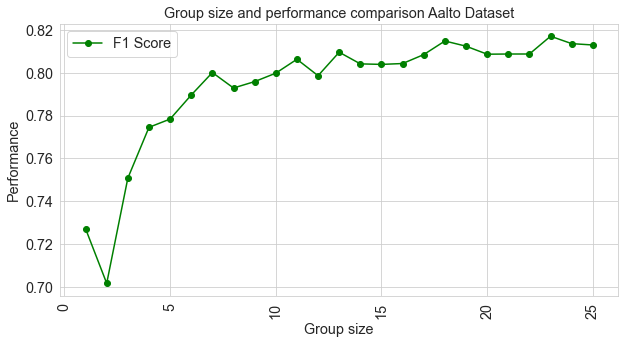

In [23]:
name_list=find_the_way('./Aalto/False/','.csv')
name_list

flag=1
for i in name_list:
    df = pd.read_csv(i) 
    col=i[16:-10]
    temp=pd.DataFrame(df.mean(),columns=[col])
    if flag:
        std=temp
        flag=0
    else:
        std[col]=temp[col]


tt=std.T
tt.index = tt.index.astype(int)
tt=tt.sort_index()
tt     


sns.set_style("whitegrid")
graph_name="GA_DT_aalto_false.pdf"
my_xticks=tt.index
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
#plt.figure(figsize=(10,10))
#plt.plot(my_xticks,tt['Acc'], linestyle='--', marker='.', color='b',label= "Separate Train & Test acc")
#plt.plot(my_xticks,cv['Acc'], linestyle='--', marker='.', color='r',label= "10-Fold CV acc")
plt.plot(my_xticks,tt[' F1-score'], linestyle='-', marker='o', color='g',label= "F1 Score")
#plt.plot(my_xticks,tt['Acc'], linestyle='-', marker='o', color='b',label= "Accuracy")
#plt.axhline(0.574329, color='r')
plt.title("Group size and performance comparison Aalto Dataset")
plt.legend(numpoints=1)
#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel("Performance")
plt.xlabel("Group size")
plt.xticks(rotation=90) 
#plt.ylim([0.69, 0.75]) 
plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)